# Preprocessing, Feature Selection and Data Reduction

### 0. Data preparation and feature selection

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR,SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.feature_extraction.text import  TfidfVectorizer, CountVectorizer

import re

In [2]:
def word_to_phrase(flist):
    plist = []
    if len(flist) > 0:
        for feature in flist:
            feature = re.sub('[_]',' ',feature)
            feature = feature.strip()
            feature_p = ''.join(feature.split(' '))
            plist.append(feature_p)
    return plist

def list_to_string(flist):
    string = ' '.join(flist)
    return string

In [3]:
ori_train = pd.read_json('train.json.zip', orient='columns', convert_dates=['created'], compression='zip')
ori_train = ori_train.reset_index()
ori_train.rename(columns={'index':'rec_id'}, inplace=True) 
train = ori_train
test =  pd.read_json('test.json.zip', orient='columns', convert_dates=['created'], compression='zip')
test = test.reset_index()
test.rename(columns={'index':'rec_id'}, inplace=True)

# remove outliers with ridiculously high prices
train = train[train['price']<=20000]
# remove outliers which the houses locate far away from most of the houses and missing values
train = train[(train['latitude'] <= 41.5) & (train['latitude'] >= 40) & (train['longitude'] >= -80) & (train['longitude'] <= -70)]
# remove outliers which have bathrooms more than bedrooms
train['diff_rooms'] = train['bedrooms'] - train['bathrooms']
train = train[train['diff_rooms']>=-1.5]

train_text = train[['description', 'features']]
test_text = test[['description', 'features']]
data_text = pd.concat([train_text, test_text], axis=0)

# tfidf
desc_tfidf = TfidfVectorizer(min_df=20, max_features=30, strip_accents='unicode',lowercase =True,
                        analyzer='word', token_pattern=r'\w{5,}', ngram_range=(1, 3),  sublinear_tf=True, stop_words = 'english')  
desc_tfidf_fit =desc_tfidf.fit_transform(data_text['description'])
desc_name = [x for x in desc_tfidf.get_feature_names()]
# standardize "feature"
data_text['features_phr'] = data_text['features'].apply(word_to_phrase)
data_text['features_phr_str'] = data_text['features_phr'].apply(list_to_string)
# tfidf 'feature'
phr_tfidf = TfidfVectorizer(min_df=2, max_features=30, strip_accents='unicode', lowercase=True, token_pattern=r'\w{3,}', stop_words='english')  
phr_tfidf_fit =phr_tfidf.fit_transform(data_text['features_phr_str'])
phr_names = [x for x in phr_tfidf.get_feature_names()]
data_text['features_phr_vec'] = pd.Series(phr_tfidf_fit.toarray().tolist())

In [4]:
data_text['features_phr_vec'] = pd.Series(phr_tfidf_fit.toarray().tolist())

In [5]:
phr_list = phr_tfidf_fit.toarray().tolist()
p_array=np.asarray(phr_list).reshape(123824, 30)
phr = pd.DataFrame(p_array, columns=["p_%d" % i for i in range(0, 30)])

desc_list = desc_tfidf_fit.toarray().tolist()
d_array=np.asarray(desc_list).reshape(123824, 30)
desc = pd.DataFrame(d_array, columns=["d_%d" % i for i in range(0, 30)])

In [6]:
text = phr.join([desc])
text

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29
0,0.0,0.269246,0.0,0.505923,0.288970,0.280043,0.000000,0.000000,0.0,0.0,...,0.382638,0.215368,0.227765,0.000000,0.000000,0.000000,0.000000,0.000000,0.154201,0.0
1,0.0,0.000000,0.0,0.000000,0.411748,0.000000,0.410219,0.360214,0.0,0.0,...,0.574625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186830,0.0
2,0.0,0.000000,0.0,0.000000,0.383966,0.000000,0.382540,0.335909,0.0,0.0,...,0.000000,0.000000,0.406729,0.185661,0.192782,0.207022,0.190337,0.205859,0.131213,0.0
3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292774,0.316650,0.201830,0.0
4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.474337,0.416516,0.0,0.0,...,0.000000,0.533560,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382024,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123819,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
123820,0.0,0.335651,0.0,0.000000,0.360240,0.349111,0.358902,0.315153,0.0,0.0,...,0.000000,0.249961,0.264349,0.000000,0.000000,0.000000,0.000000,0.000000,0.178970,0.0
123821,0.0,0.693074,0.0,0.000000,0.000000,0.720867,0.000000,0.000000,0.0,0.0,...,0.408558,0.000000,0.196207,0.187958,0.195168,0.209584,0.192693,0.208406,0.000000,0.0
123822,0.0,0.493459,0.0,0.000000,0.000000,0.513247,0.527642,0.463324,0.0,0.0,...,0.324935,0.309660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [7]:
def remove_correlated_features(X):
    corr_threshold = 0.9
    corr = X.corr()
    drop_columns = np.full(corr.shape[0], False, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= corr_threshold:
                drop_columns[j] = True
    columns_dropped = X.columns[drop_columns]
    X.drop(columns_dropped, axis=1, inplace=True)
    return columns_dropped

In [8]:
def remove_less_significant_features(X, Y):
    sl = 0.05
    regression_ols = None
    columns_dropped = np.array([])
    for itr in range(0, len(X.columns)):
        regression_ols = sm.OLS(Y, X).fit()
        max_col = regression_ols.pvalues.idxmax()
        max_val = regression_ols.pvalues.max()
        if max_val > sl:
            X.drop(max_col, axis='columns', inplace=True)
            columns_dropped = np.append(columns_dropped, [max_col])
        else:
            break
    regression_ols.summary()
    return columns_dropped

In [9]:
columns_dropped_corr = remove_correlated_features(text)

In [10]:
columns_dropped_corr

Index(['p_21', 'p_28', 'd_14', 'd_21', 'd_24', 'd_26', 'd_27'], dtype='object')

In [11]:
ori_train=pd.read_json("modified_data/modified_train.json")
ori_test = pd.read_json("modified_data/modified_test.json")

ori_train = ori_train.drop(columns=['rec_id', 'building_id','description','display_address','manager_id','features','photos','street_address','features_phr_vec','description_vec','text_vec'])
ori_train = ori_train.reset_index()
train = ori_train.join(text)

ori_test = ori_test.drop(columns=['rec_id', 'building_id','description','display_address','manager_id','features','photos','street_address','features_phr_vec','description_vec','text_vec'])
ori_test = ori_test.reset_index()
test = ori_test.join(text)

Listing_id_train = train['listing_id']
y_train = train['interest_level']
X_train = train.drop(columns=['index','listing_id', 'interest_level', 'diff_rooms'])

Listing_id_test = test['listing_id']
X_test = test.drop(columns=['index', 'listing_id'])

y_train_map = {"low":0, "medium": 1, "high": 2}
y_train = y_train.map(y_train_map)

In [12]:
X = pd.concat([X_train, X_test])

In [13]:
X_train = X[:49165]
X_test = X[49165:]

#### Here we try to drop some function that same to have little connection with "interest level". However, this leads to overfitting

In [14]:
columns_dropped_insig = remove_less_significant_features(X_train, y_train)
X_sig = X.drop(columns=columns_dropped_insig)
columns_dropped_insig

c:\users\xixi6\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3987: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array(['d_8', 'd_6', 'd_2', 'p_18', 'd_10', 'p_0', 'p_1', 'd_1', 'd_7',
       'd_28', 'd_11', 'd_12', 'created', 'd_25', 'manager_id_num',
       'p_11', 'd_3', 'd_5', 'd_4'], dtype='<U32')

In [15]:
# apply PCA
X_pca = PCA(n_components=6).fit_transform(X)

In [16]:
X_train_pca = X_pca[:49165]
X_test_pca = X_pca[49165:]

In [17]:
X_pca

array([[ 2.68220463e+09, -1.40802375e+03, -1.06198675e+03,
        -5.20643463e+02,  6.22830316e+00,  1.50257780e-02],
       [ 1.38555063e+09,  6.78842110e+01, -3.40780777e+03,
        -3.00809707e+02,  1.30897863e-01, -1.58722182e-02],
       [ 2.54327663e+09, -2.82715361e+02, -4.31639052e+03,
        -1.19265360e+03,  2.46025378e-02, -7.20692306e-03],
       ...,
       [-2.25841037e+09, -1.21924159e+03,  4.90163757e+03,
        -1.72368372e+03, -5.34270146e+00, -2.59759697e-02],
       [-3.29191737e+09,  3.38329068e+03, -4.19201386e+03,
         4.04215731e+02,  2.14773711e+00, -4.38212756e-02],
       [-2.42644137e+09,  1.09146680e+03,  3.71130324e+03,
        -1.48835271e+03,  2.68635107e+00, -8.21113029e-03]])

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)
X_train_scaled = X_scaled[:49165]
X_test_scaled = X_scaled[49165:]

In [19]:
X_scaled

array([[ 1.19887551, -0.1843426 , -0.28462093, -0.41173425,  1.71623254,
         0.01150291],
       [ 0.61930499,  0.0088876 , -0.91331968, -0.23788575,  0.0360694 ,
        -0.0121509 ],
       [ 1.13677832, -0.03701393, -1.15682711, -0.94317199,  0.00677932,
        -0.00551722],
       ...,
       [-1.00945053, -0.15962669,  1.31367799, -1.3631202 , -1.47220164,
        -0.01988578],
       [-1.47140121,  0.44295035, -1.12349317,  0.3196611 ,  0.5918171 ,
        -0.03354716],
       [-1.08455601,  0.14289804,  0.99465889, -1.17701618,  0.74023422,
        -0.00628599]])

### 1. Run SVC in RBF kernel with gamma=0.001, C=1 ==> Overfitting

In [20]:
clf = SVC(kernel='rbf',gamma=0.001,C=1, probability=True, cache_size=7000)
clf.fit(X_train_scaled, y_train)
print("score:", clf.score(X_train_scaled, y_train))

score: 0.6937455506966338


In [21]:
y_test = clf.predict_proba(X_test_scaled)

In [22]:
# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

In [23]:
def to_result_format(X):
    res = pd.DataFrame(y_test,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    res.to_csv('submission.csv', index = None)
    return res

In [24]:
X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)

In [25]:
res

,listing_id,high,medium,low
0,7142618,0.033406,0.116897,0.849697
1,7210040,0.009449,0.049148,0.941403
2,7174566,0.018874,0.079839,0.901287
3,7191391,0.013305,0.061553,0.925142
4,7171695,0.022384,0.087799,0.889817
...,...,...,...,...
74654,6928108,0.063056,0.235519,0.701425
74655,6906674,0.063177,0.231472,0.705351
74656,6897967,0.051006,0.215578,0.733416
74657,6842183,0.029874,0.150575,0.819551


#### Logloss=0.85740

### 2. SVC RBF with gamma=0.01, C=10

In [33]:
clf = SVC(kernel='rbf',gamma=0.01,C=10, probability=True, cache_size=7000)
clf.fit(X_train_scaled, y_train)

SVC(C=10, break_ties=False, cache_size=7000, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [38]:
print("score:", clf.score(X_train_scaled, y_train))

score: 0.6937455506966338


In [34]:
y_test = clf.predict_proba(X_test_scaled)

In [35]:
# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

In [36]:
X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)

In [37]:
res

,listing_id,high,medium,low
0,7142618,0.073989,0.224054,0.701957
1,7210040,0.045034,0.197349,0.757617
2,7174566,0.056601,0.210352,0.733047
3,7191391,0.052601,0.205832,0.741567
4,7171695,0.065348,0.217684,0.716968
...,...,...,...,...
74654,6928108,0.070777,0.206574,0.722649
74655,6906674,0.091524,0.231804,0.676672
74656,6897967,0.073350,0.211076,0.715574
74657,6842183,0.079337,0.246110,0.674554


#### Logloss = 0.79862

### 3. Run SVC in Sigmoid kernel with large C(=100)

In [111]:
clf1 = SVC(kernel='sigmoid',gamma='auto',C=100, probability=True, cache_size=7000)
clf1.fit(X_train_scaled, y_train)
print("score:", clf1.score(X_train_scaled, y_train))

score: 0.5259839316587003


In [112]:
y_test = clf1.predict_proba(X_test_scaled)

In [113]:
# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

In [114]:
X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)

In [115]:
res

,listing_id,high,medium,low
0,7142618,0.068086,0.232755,0.699158
1,7210040,0.081728,0.215623,0.702649
2,7174566,0.072884,0.226396,0.700720
3,7191391,0.077253,0.220280,0.702467
4,7171695,0.071627,0.227033,0.701340
...,...,...,...,...
74654,6928108,0.087826,0.217263,0.694912
74655,6906674,0.083057,0.218494,0.698449
74656,6897967,0.083584,0.220175,0.696241
74657,6842183,0.068529,0.234205,0.697265


## Cross Validation

### 4. Use GridSearchCV to tune the parameters 

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

def tuneParameters(X, y, tuned_parameters, X_test):
    score = 'accuracy'
    
    print('# Tuning hyper-parameters for %s' % score)
    print()

    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    grid = GridSearchCV(
        SVC(cache_size=7000, probability=True), param_grid=tuned_parameters,scoring='accuracy', cv=cv
    )
    grid.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()


    return grid.predict_proba(X_test)

### 5. Tune parameter 'gamma' for RBF SVC 

In [21]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.1, 1, 10], 'C': [1]}]

proba = tuneParameters(X_train_scaled, y_train, tuned_parameters, X_test_scaled)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.694 (+/-0.000) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.694 (+/-0.000) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.687 (+/-0.001) for {'C': 1, 'gamma': 10, 'kernel': 'rbf'}



array([[0.65463514, 0.24342411, 0.10194075],
       [0.71377991, 0.22769598, 0.05852411],
       [0.73446435, 0.21927278, 0.04626288],
       ...,
       [0.73325219, 0.22626623, 0.04048158],
       [0.68325815, 0.22810773, 0.08863412],
       [0.69135485, 0.23240005, 0.0762451 ]])

In [22]:
tuned_parameters =  [{'kernel': ['rbf'], 'gamma': [1], 'C': [0.1, 1, 10]}]
proba = tuneParameters(X_train_scaled, y_train, tuned_parameters, X_test_scaled)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.694 (+/-0.000) for {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.694 (+/-0.000) for {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
0.694 (+/-0.000) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}



In [24]:
y_test = proba

In [25]:
# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

In [26]:
def to_result_format(X):
    res = pd.DataFrame(y_test,columns=['high', 'low', 'medium'])
    temp = res['low']
    res = res.drop(columns = {'low'})
    res.insert(2,'low',temp)
    res.insert
    res.insert(0,'listing_id',X['listing_id'])
    res.to_csv('submission.csv', index = None)
    return res

In [27]:
X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)

In [28]:
res

,listing_id,high,medium,low
0,7142618,0.075255,0.227774,0.696971
1,7210040,0.078775,0.221689,0.699536
2,7174566,0.078451,0.215194,0.706356
3,7191391,0.069244,0.214827,0.715928
4,7171695,0.083647,0.219448,0.696905
...,...,...,...,...
74654,6928108,0.133472,0.282680,0.583848
74655,6906674,0.071335,0.223896,0.704770
74656,6897967,0.043876,0.219808,0.736315
74657,6842183,0.110366,0.219891,0.669743


#### Logloss = 0.76775

In [29]:
tuned_parameters =  [{'kernel': ['rbf'], 'gamma': [1], 'C': [10, 50, 100]}]
proba = tuneParameters(X_train_scaled, y_train, tuned_parameters, X_test_scaled)

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 50, 'gamma': 1, 'kernel': 'rbf'}

Grid scores on development set:

0.694 (+/-0.000) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
0.695 (+/-0.001) for {'C': 50, 'gamma': 1, 'kernel': 'rbf'}
0.694 (+/-0.003) for {'C': 100, 'gamma': 1, 'kernel': 'rbf'}



In [30]:
y_test = proba

# change the order of columns in result
y_test_df = pd.DataFrame(y_test)
cols = y_test_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
y_test = y_test_df[cols].to_numpy()

X_test_df = pd.DataFrame(X_test).join([Listing_id_test])
res = to_result_format(X_test_df)
res

,listing_id,high,medium,low
0,7142618,0.078605,0.230955,0.690441
1,7210040,0.075080,0.216752,0.708168
2,7174566,0.072677,0.194027,0.733296
3,7191391,0.064677,0.199866,0.735457
4,7171695,0.085349,0.212966,0.701685
...,...,...,...,...
74654,6928108,0.156722,0.416880,0.426398
74655,6906674,0.075915,0.222619,0.701466
74656,6897967,0.030176,0.205846,0.763977
74657,6842183,0.148303,0.215532,0.636165


### Logloss = 0.75157

### 6. Visualization of parameter tuning

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
def plotSVC(X, y, clfs, titles):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() -1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max - x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    for i, clf in enumerate(clfs):
        plt.subplot(2, 2, i + 1)
        #print(np.c_[xx.ravel(), yy.ravel()])
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
        plt.xlabel('Sepal length')
        plt.ylabel('Sepal width')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(titles[i])
        
    plt.show()

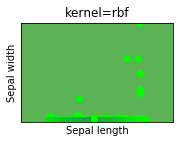

In [30]:
clfs = [clf]
plotSVC(X_test_scaled, y_test, clfs, ["kernel=rbf"])